In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from torchvision.transforms.functional import to_tensor
from torch.amp import autocast, GradScaler

import os
import numpy as np
import subprocess
from PIL import Image
import shutil

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
device = 'cuda'

In [3]:
def read_pickle(path) -> torch.tensor:
    return torch.load(path)

def pickle_files_path_list(path) -> list:
    path_list = []
    for top, dirs, files in os.walk(path):
        for nm in files:
            path_list.append(os.path.join(top, nm))
    return path_list

def preload_tensors(path_list, device):
    data = []
    for path in path_list:
        tensor = torch.load(path)  # Load tensor from disk
        video, label = tensor['video'].to(device), tensor['label'].to(device)
        data.append((video, label))
    return data

In [4]:
import torch

def save_checkpoint(state, filename="checkpoint.pth"):
    """Save model and optimizer state to a file."""
    torch.save(state, filename)

def load_checkpoint(filename="checkpoint.pth"):
    """Load model and optimizer state from a file."""
    checkpoint = torch.load(filename)
    return checkpoint

In [5]:
torch.tensor([1,2])+np.random.uniform(0, 0.001, 2)

tensor([1.0003, 2.0006], dtype=torch.float64)

In [6]:
X = torch.tensor([[1,2],[3,4]], dtype=torch.float32).mean()
torch.FloatTensor(1, 1584).uniform_(0, X*0.01)

tensor([[0.0058, 0.0187, 0.0044,  ..., 0.0185, 0.0034, 0.0195]])

In [27]:
class Trainer:
    def __init__(self, model, device, optimizer, loss_fn, save=False):
        self.device = device
        self.scaler = GradScaler()  # Automatic Mixed Precision
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.model = model
        self.save = save

    def train_step_pickle(self, epoch, preloaded_data):
        self.model.train()
        train_loss, total_correct, total_samples = 0, 0, 0

        for X, y in preloaded_data:
            # Forward pass with AMP
            #num = X.mean() * 0.01
            #X = X+num
            with autocast('cuda'):
                y_pred = self.model(X)
                loss = self.loss_fn(y_pred, y)
                train_loss += loss.item()

            # Backward pass with scaling
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad()

            # Accuracy computation
            y_pred_class = torch.argmax(y_pred, dim=1)
            total_correct += (y_pred_class == y).sum().item()
            total_samples += y.size(0)

        acc = total_correct * 100 / total_samples
        train_loss /= len(preloaded_data)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Accuracy: {acc:.2f}")

    def test_step_pickle(self, epoch,preloaded_data):
        self.model.eval()
        test_loss, acc = 0, 0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for X, y in preloaded_data:
                # Use AMP for inference
                with autocast('cuda'):
                    y_pred = self.model(X)
                    loss = self.loss_fn(y_pred, y)
                    test_loss += loss.item()

                # Compute predictions and accuracy
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                total_correct += (y_pred_class == y).sum().item()
                total_samples += y.size(0)

            acc = total_correct * 100 / total_samples
            test_loss = test_loss / len(preloaded_data)
            print(f"Epoch: {epoch} | Test Loss: {test_loss:.4f} | Accuracy: {acc:.2f}")
            if self.save:
                print(f"Saving model at epoch {epoch}...")
                save_checkpoint({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_metric': acc
                }, filename=f"BUMBLEBEE_acc={acc:.2f}_{epoch=}_real.pth")
            print("************************")


In [50]:
class Trainer:
    def __init__(self, model, device, optimizer, scheduler, loss_fn, save=False):
        self.device = device
        self.scaler = GradScaler()  # Automatic Mixed Precision
        self.optimizer = optimizer
        self.scheduler = scheduler  # Add scheduler
        self.loss_fn = loss_fn
        self.model = model
        self.save = save

    def train_step_pickle(self, epoch, preloaded_data):
        self.model.train()
        train_loss, total_correct, total_samples = 0, 0, 0

        for X, y in preloaded_data:
            # Forward pass with AMP
            with autocast('cuda'):
                y_pred = self.model(X)
                loss = self.loss_fn(y_pred, y)
                train_loss += loss.item()

            # Backward pass with scaling
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad()

            # Accuracy computation
            y_pred_class = torch.argmax(y_pred, dim=1)
            total_correct += (y_pred_class == y).sum().item()
            total_samples += y.size(0)

        acc = total_correct * 100 / total_samples
        train_loss /= len(preloaded_data)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Accuracy: {acc:.2f}")

        # Step scheduler if it's not ReduceLROnPlateau
        if not isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            self.scheduler.step()

    def test_step_pickle(self, epoch, preloaded_data):
        self.model.eval()
        test_loss, total_correct, total_samples = 0, 0, 0

        with torch.no_grad():
            for X, y in preloaded_data:
                # Use AMP for inference
                with autocast('cuda'):
                    y_pred = self.model(X)
                    loss = self.loss_fn(y_pred, y)
                    test_loss += loss.item()

                # Compute predictions and accuracy
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                total_correct += (y_pred_class == y).sum().item()
                total_samples += y.size(0)

            acc = total_correct * 100 / total_samples
            test_loss = test_loss / len(preloaded_data)
            print(f"Epoch: {epoch} | Test Loss: {test_loss:.4f} | Accuracy: {acc:.2f}")
            
            # Step scheduler if ReduceLROnPlateau
            if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(test_loss)  # Use validation loss as the metric

            if self.save:
                print(f"Saving model at epoch {epoch}...")
                save_checkpoint({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_metric': acc
                }, filename=f"BUMBLEBEE_acc={acc:.2f}_loss={loss:.5f}_{epoch=}_real.pth")
            print("************************")


In [51]:
train_preloaded = preload_tensors(pickle_files_path_list('/kaggle/input/include-landmark/ISL_pickle/Train_data'), device='cuda:0')
test_preloaded = preload_tensors(pickle_files_path_list('/kaggle/input/include-landmark/ISL_pickle/Test_data'), device='cuda:0')

<ipython-input-3-f4f9ec948b67>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)  # Load tensor from disk


In [52]:
import torch
import torch.nn as nn

class BUMBLEBEE(nn.Module):
    def __init__(self, input_dim, num_frames, keypoint_dim, num_classes, d_model=128, num_heads=4, num_layers=2, dropout=0.1):
        super(BUMBLEBEE, self).__init__()

        self.num_frames = num_frames
        self.keypoint_dim = keypoint_dim

        # Linear layer to project flattened input to sequence embeddings
        self.input_projection = nn.Linear(input_dim, num_frames * d_model)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, num_frames, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, input_dim) where input_dim = num_frames * 2 * keypoint_dim
        """
        batch_size = x.size(0)

        # Project input to a sequence of embeddings: (batch_size, input_dim) -> (batch_size, num_frames, d_model)
        x = self.input_projection(x)  # (batch_size, num_frames * d_model)
        x = x.view(batch_size, self.num_frames, -1)  # (batch_size, num_frames, d_model)

        # Add positional encoding
        x = x + self.positional_encoding[:, :self.num_frames, :]

        # Transformer encoder
        x = self.transformer(x)  # (batch_size, num_frames, d_model)

        # Global average pooling across frames
        x = torch.mean(x, dim=1)  # (batch_size, d_model)

        # Classification head
        x = self.fc(x)  # (batch_size, num_classes)
        return x

In [66]:
shutil.rmtree('/kaggle/working')

OSError: [Errno 16] Device or resource busy: '/kaggle/working'

In [57]:
model = BUMBLEBEE(input_dim=1584, num_frames=12, keypoint_dim=66, num_classes=50, d_model=40, num_heads=2, num_layers=1, dropout=0.6
).to(device)
model = nn.DataParallel(model)  # Distribute model across GPUs

In [69]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)

# Define the scheduler without the verbose parameter
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    min_lr=1e-6  # Set a minimum learning rate
)


# Define the loss function
loss_fn = nn.CrossEntropyLoss()


In [70]:
trainer = Trainer(device=device,optimizer=optimizer,loss_fn=loss_fn,save=True,scheduler=scheduler, model=model)
epochs = 2500
for epoch in range(epochs):
    trainer.train_step_pickle(epoch=epoch, preloaded_data=train_preloaded)
    trainer.test_step_pickle(epoch=epoch, preloaded_data=test_preloaded)

Epoch: 1500 | Train Loss: 0.6637 | Accuracy: 80.72
Epoch: 1500 | Test Loss: 1.6421 | Accuracy: 52.38
Saving model at epoch 1500...
************************
Epoch: 1501 | Train Loss: 0.6849 | Accuracy: 79.48
Epoch: 1501 | Test Loss: 1.6363 | Accuracy: 51.08
Saving model at epoch 1501...
************************
Epoch: 1502 | Train Loss: 0.6477 | Accuracy: 81.47
Epoch: 1502 | Test Loss: 1.6406 | Accuracy: 50.22
Saving model at epoch 1502...
************************
Epoch: 1503 | Train Loss: 0.6812 | Accuracy: 79.73
Epoch: 1503 | Test Loss: 1.6439 | Accuracy: 51.52
Saving model at epoch 1503...
************************
Epoch: 1504 | Train Loss: 0.6627 | Accuracy: 80.10
Epoch: 1504 | Test Loss: 1.6478 | Accuracy: 51.95
Saving model at epoch 1504...
************************
Epoch: 1505 | Train Loss: 0.6619 | Accuracy: 79.48
Epoch: 1505 | Test Loss: 1.6532 | Accuracy: 51.95
Saving model at epoch 1505...
************************
Epoch: 1506 | Train Loss: 0.6603 | Accuracy: 79.85
Epoch: 1506 |

In [68]:
# Load the saved checkpoint
checkpoint = torch.load('/kaggle/input/54_acc/pytorch/default/1/BUMBLEBEE_acc54.55_loss1.69383_epoch1461.pth')

# Load only the model state_dict
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-68-7545e6bf33b6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/54_acc/pytorch/default/1/BUMBLEBEE_acc54.55_loss1.693

<All keys matched successfully>

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py:117: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


<Figure size 100000x100000 with 0 Axes>

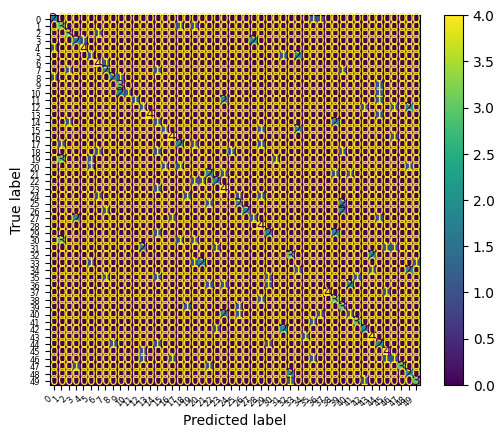

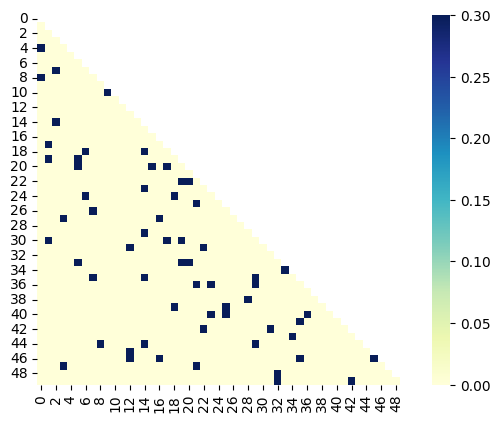

In [32]:
# Plotting Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import confusion_matrix

y_true = []
y_preds = []

model.eval()
with torch.no_grad():
  for X, y in test_preloaded:
    X, y = X.to(device), y.to(device)


    y_pred = model(X)
    y_pred_class = y_pred.argmax(dim=1)

    y_true.extend(y.cpu().numpy())
    y_preds.extend(y_pred_class.cpu().numpy())
plt.figure(figsize=(1000, 1000))
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(50))
disp.plot(cmap="viridis")  # Customize colormap if needed
plt.xticks(fontsize=6, rotation=45, ha="right")
plt.yticks(fontsize=6)
plt.show()
import seaborn as sns
def cm_disp(cm):
    mask = np.zeros_like(cm)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(cm, mask=mask, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()
cm_disp(cm)

<Figure size 100000x100000 with 0 Axes>

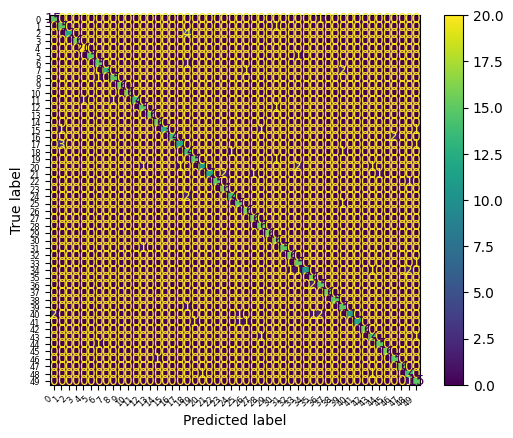

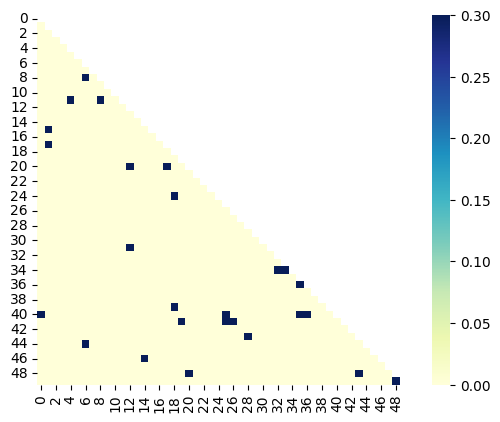

In [33]:
# Plotting Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import confusion_matrix

y_true = []
y_preds = []

model.eval()
with torch.no_grad():
  for X, y in train_preloaded:
    X, y = X.to(device), y.to(device)


    y_pred = model(X)
    y_pred_class = y_pred.argmax(dim=1)

    y_true.extend(y.cpu().numpy())
    y_preds.extend(y_pred_class.cpu().numpy())
plt.figure(figsize=(1000, 1000))
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(50))
disp.plot(cmap="viridis")  # Customize colormap if needed
plt.xticks(fontsize=6, rotation=45, ha="right")
plt.yticks(fontsize=6)
plt.show()
import seaborn as sns
def cm_disp(cm):
    mask = np.zeros_like(cm)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(cm, mask=mask, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()
cm_disp(cm)